# **Capstone Project: Saliford Motors**

## **Imports and data loading**

In [1]:
# ========================
# Core Libraries
# ========================
import numpy as np
import pandas as pd

# Display all columns in outputs
pd.set_option('display.max_columns', None)

# ========================
# Visualization Libraries
# ========================
import seaborn as sns
from matplotlib import pyplot as plt
from xgboost import plot_importance  # For feature importance plots

# ========================
# Modeling Libraries
# ========================
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ========================
# Model Evaluation
# ========================
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve)

# ========================
# Model Training Utilities
# ========================
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

# ========================
# Model Persistence
# ========================
import pickle

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv("../data/HR_capstone_dataset.csv")

In [3]:
# Create a copy of the original dataframe to preserve the raw data
df = df0.copy()

## **Exploratory Data Analysis (EDA)**

### **Gather basic information about the data**

In [4]:
# Display first few rows of the dataframe
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
# Determine if target variable is imbalanced
df['left'].value_counts(normalize = True)

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

In [6]:
# Check the number of rows and columns in the dataset
df.shape

(14999, 10)

In [7]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [8]:
# Gather descriptive statistics about the data
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### **Rename Columns**

In [9]:
# Standardize column names by renaming them to `snake_case` format.
df.rename(columns = {
    'Work_accident' : 'work_accident',
    'average_montly_hours' : 'average_monthly_hours',
    'Department' : 'department'},
          inplace = True)

# Display all column names after the update
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### **Check for missing values**

In [10]:
# Check for missing values
df.isna().any(axis = 1).sum()

np.int64(0)

### **Check for duplicated values**

In [11]:
# Check for duplicates
df.duplicated().sum()

np.int64(3008)

In [12]:
# Drop duplicates and save resulting dataframe in a new variable
df.drop_duplicates(inplace = True)

# Confirm that it worked
df.shape

(11991, 10)

### **Check for outliers**

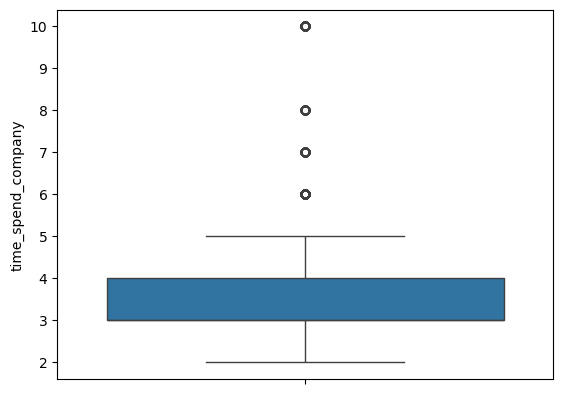

In [13]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
sns.boxplot(y = 'time_spend_company', data = df)
plt.show()

In [14]:
# Determine the number of rows containing outliers
df[df['time_spend_company'] > 5].shape

(824, 10)

> Different models have varying sensitivity to outliers. Logistic regression assumes clean, well-behaved data and can be sensitive to extreme outliers. In contrast, models like Random Forest and XGBoost are generally robust to outliers, while Naive Bayes’ sensitivity depends on the variant used.

### **Visualizations**

#### **Helper Functions**

In [15]:
def boxplotter(col, figsize = (5, 2), fliersize = 1):
    plt.figure(figsize = figsize)
    sns.set_palette("viridis")
    sns.boxplot(x = df[col], fliersize = fliersize)
    plt.tight_layout()
    plt.show()

In [16]:
def histogrammer(col, figsize = (8, 5), discrete = False, bins = 'auto'):
    plt.figure(figsize = figsize)
    sns.set_palette("viridis")
    sns.histplot(x = df[col], discrete = discrete, bins = bins)
    plt.tight_layout()
    plt.show()

#### **`satisfaction_level`**
_The employee's self reported satisfaction level [0-1]_

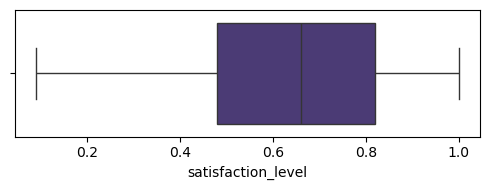

In [17]:
boxplotter('satisfaction_level')

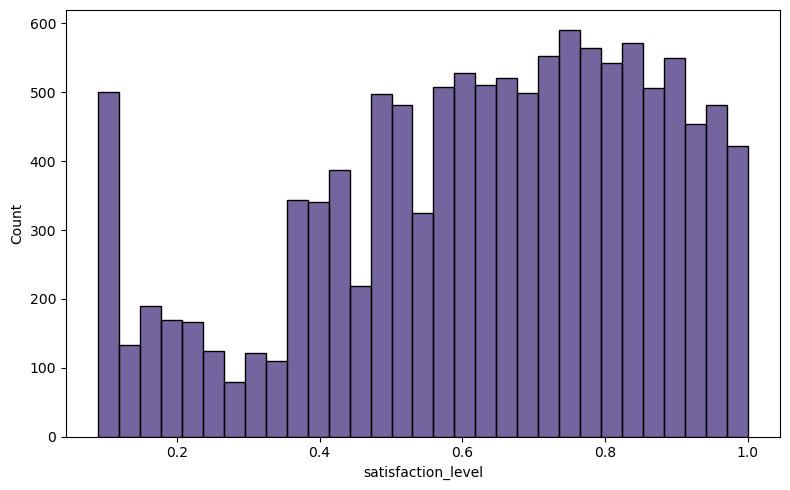

In [18]:
histogrammer('satisfaction_level')

#### **`last_evaluation`**
_Score of employee's last performance review [0–1]_

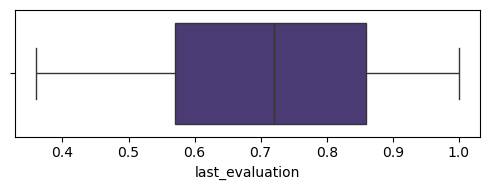

In [19]:
boxplotter('last_evaluation')

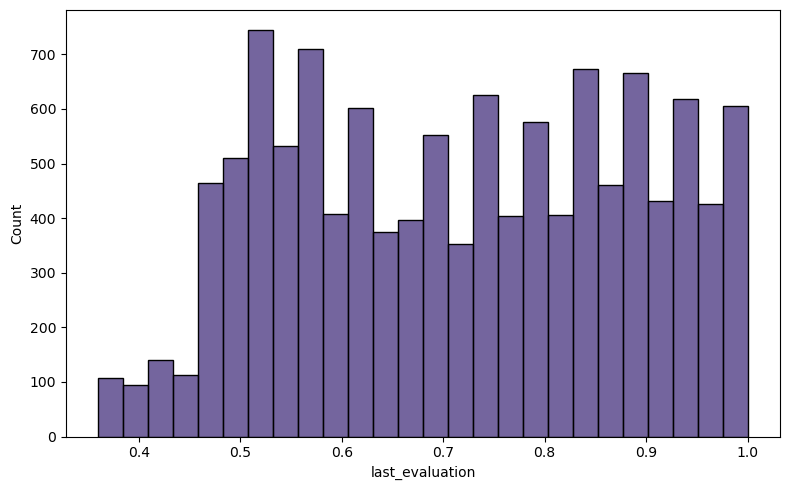

In [20]:
histogrammer('last_evaluation')

#### **`average_monthly_hours`**
_Number of projects employee contributes to_

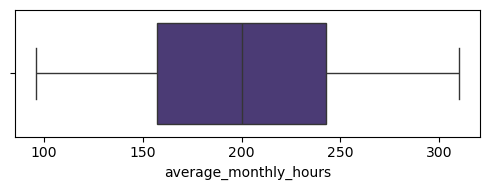

In [21]:
boxplotter('average_monthly_hours')

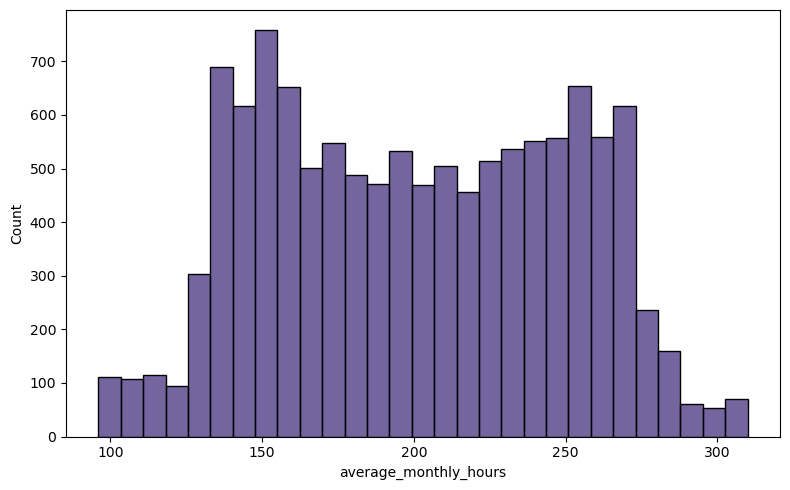

In [22]:
histogrammer('average_monthly_hours')

#### **`time_spend_company`**
_How long the employee has been with the company (years)_

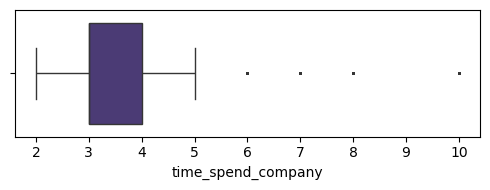

In [23]:
boxplotter('time_spend_company')

#### **`number_project`**
_Number of projects employee contributes to_

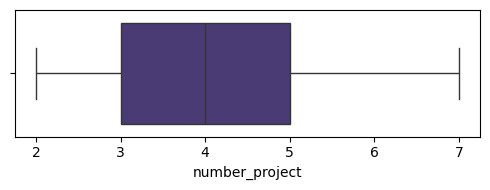

In [24]:
boxplotter('number_project')

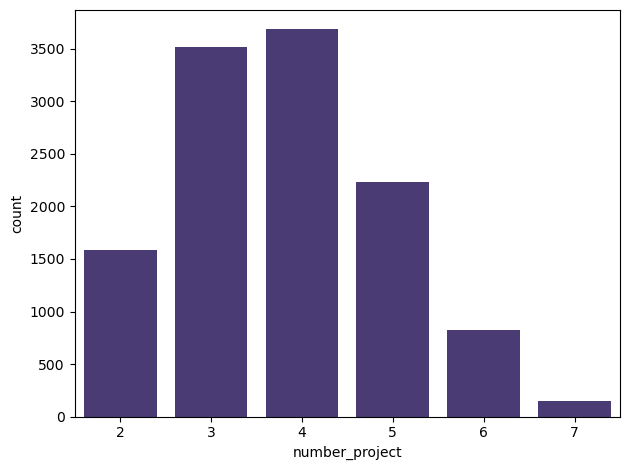

In [25]:
sns.countplot(x = 'number_project', data = df)
plt.tight_layout()
plt.show()

#### **`department`**
_The employee's department_

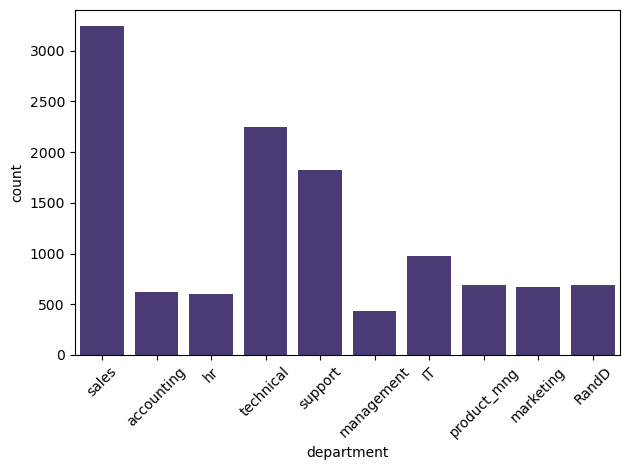

In [26]:
sns.set_palette("viridis")
sns.countplot(x = 'department', data = df)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

#### **`work_accident`**
_Whether or not the employee experienced an accident while at work_

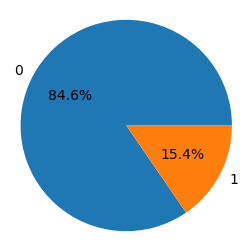

In [27]:
plt.figure(figsize = (3,3))
sns.set_palette("tab10")
plt.pie(df['work_accident'].value_counts(), labels = df['work_accident'].value_counts().index, autopct = '%1.1f%%')
plt.axis('equal');

#### **`left`**
_Whether or not the employee left the company_

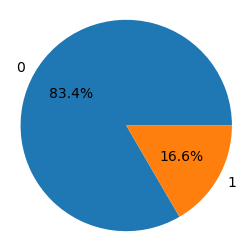

In [28]:
plt.figure(figsize = (3,3))
sns.set_palette("tab10")
plt.pie(df['left'].value_counts(), labels = df['left'].value_counts().index, autopct = '%1.1f%%')
plt.axis('equal');

#### **`promotion_last_5years`**
_Whether or not the employee was promoted in the last 5 years_

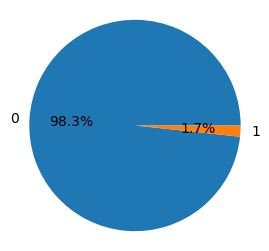

In [29]:
plt.figure(figsize = (3,3))
sns.set_palette("tab10")
plt.pie(df['promotion_last_5years'].value_counts(), labels = df['promotion_last_5years'].value_counts().index, autopct = '%1.1f%%')
plt.axis('equal');

#### **`salary`**
_The employee's salary (low, medium, or high)_

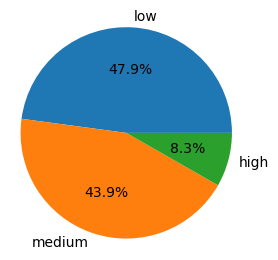

In [30]:
plt.figure(figsize = (3,3))
sns.set_palette("tab10")
plt.pie(df['salary'].value_counts(), labels = df['salary'].value_counts().index, autopct = '%1.1f%%')
plt.axis('equal');

#### **Data Insights**

* While many employees have satisfaction levels above 0.5, a concerning number report extremely low satisfaction scores below 0.1, indicating significant dissatisfaction within a portion of the workforce.
* Employee evaluations appear to be generally generous, with most scores exceeding 0.5. A small number fall in the lower range of 0.3 to 0.5, with the minimum recorded score at 0.36.
* The majority of employees logged between 140 and 270 average monthly hours, though there are noticeable outliers on both ends of the spectrum.
* Most surveyed employees are from `sales`, `technical`, and `support`, creating a departmental imbalance. This may introduce sampling bias, as the results could disproportionately reflect the experiences of these groups and limit the generalizability of the findings across the company.
* The proportions of employees who experienced a work_accident and those who left the company are surprisingly similar, suggesting a possible correlation between the two variables.
* Only a small percentage of employees received a promotion in the past five years, indicating limited upward mobility within the organization.

## **Modeling Approach Overview**

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg" width="600">
</div>

1) Split the data into train/validation/test sets (60/20/20)

2) Fit models and tune hyperparameters on the training set

3) Perform final model selection on the validation set

4) Assess the champion model's performance on the test set

### **Binomial Logistic Regression assumptions**

1) **Independent observations** ✅ (Assumed)

2) **No extreme outliers** ✅ (Winsorized)

3) **Little to no multicollinearity among X predictors** ❌ (Violated)

4) **Linear relationship between X and the logit of y** ❌ (Violated)

> * Assume that the observations are independent for this project.
>
> * The linear relationship between the predictor variables (X) and the logit of the target (y) will be assessed after fitting the logistic regression model.
> 
> _In practice, modeling assumptions are often violated._

### **Gaussian Naive Bayes assumptions**

1) **Class-conditional independence for each predictor** ✅ (Assumed)

2) **Class-conditional normality is assumed for each predictor** ✅ (Assumed)

3) **Assumes continuous (or numeric) predictors**

> Although the model assumes normality per feature per class, in practice, it can still perform reasonably well even if this assumption is mildly violated.
> 
> The dataset consists of mainly continuous variables, where the categorical variables like `department` and `salary` are one-hot/label encoded.

### **Decision Tree Characteristics (Random Forest / XGBoost)**

1) Decision trees do not use distance-based calculations. Therefore, they do not require normalization or standardization of features, and raw numeric values work just fine.

2) Both continuous and categorical variables can be used.

3) Decision trees do not assume any specific data distribution, linearity, or independence among predictors.

### **Train-Validation-Test Split**

In [31]:
# Isolate X variables
X = df.drop(['left'], axis = 1)

# Isolate y variable
y = df['left']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.25, random_state = 0)

# Verify number of samples in partitioned data
total_obs = df.shape[0]
print(X_train.shape[0] / total_obs)
print(X_val.shape[0] / X_train.shape[0])
print(X_test.shape[0] / total_obs)

0.5999499624718538
0.3333333333333333
0.20006671670419482


### **Build Model-Specific Pipelines**

In [32]:
# Treated pipeline: For Logistic Regression and Naive Bayes (outlier-sensitive)
X_train_treated = X_train.copy()
X_val_treated = X_val.copy()
X_test_treated = X_test.copy()

# Raw pipeline: For Random Forest and XGBoost (robust to outliers)
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
X_test_raw = X_test.copy()

### **Outlier Imputation**

In [33]:
# Isolate the variable with outliers as identified in the earlier E.D.A
outlier_cols = ['time_spend_company']

# Winsorize the outlier values in the predictor variables datasets using 95 percentile values from the train set
for col in outlier_cols:
    cap = X_train_treated[col].quantile(0.95)
    for df in [X_train_treated, X_val_treated, X_test_treated]:
        df[col] = np.where(df[col] > cap, cap, df[col])

## **Feature Engineering**

### **Helper Function**

In [34]:
datasets = [X_train_treated, X_val_treated, X_test_treated, X_train_raw, X_val_raw, X_test_raw]

def add_features(datasets, new_feature, col1, col2, op):
    for df in datasets:
        if op == '+':
            df[new_feature] = df[col1] + df[col2]
        elif op == '-':
            df[new_feature] = df[col1] - df[col2]
        elif op == '*':
            df[new_feature] = df[col1] * df[col2]
        else:
            df[new_feature] = df[col1] / df[col2]

### **Feature Creation**

#### **`hours_per_project`**
_Reflects how much time is spent per project_

In [35]:
add_features(datasets, 'hours_per_project', 'average_monthly_hours', 'number_project', '/')

#### **`satisfaction_gap`**
_Indicates churn signal_

In [36]:
add_features(datasets, 'satisfaction_gap', 'last_evaluation', 'satisfaction_level', '-')

#### **`engagement_score`**
_Combines emotional and performance metrics_

In [37]:
add_features(datasets, 'engagement_score', 'satisfaction_level', 'last_evaluation', '*')

#### **`loyalty_score`**
_Captures long term satisfaction_

In [38]:
add_features(datasets, 'loyalty_score', 'satisfaction_level', 'time_spend_company', '*')

#### **`avg_projects_per_year`**
_Normalizes project count by tenure_

In [39]:
add_features(datasets, 'avg_projects_per_year', 'number_project', 'time_spend_company', '/')

### **Variable Encoding**

#### **Logistic Regression & Naive Bayes**

In [40]:
# Fit OHE on X_train_treated
X_train_treated = pd.get_dummies(X_train_treated, columns = ['department', 'salary'], drop_first = True, dtype = int)
cols = X_train_treated.columns

# Apply to val/test using same structure
X_val_treated = pd.get_dummies(X_val_treated, columns = ['department', 'salary'], drop_first = True, dtype = int)
X_test_treated = pd.get_dummies(X_test_treated, columns = ['department', 'salary'], drop_first = True, dtype = int)

#### **Random Forest & XGBoost**

In [41]:
# Encode 'salary' to ordinal numeric values and convert 'department' to categorical codes 
salary_map = {'low': 0, 'medium': 1, 'high': 2}

for df in [X_train_raw, X_val_raw, X_test_raw]:
    df['salary'] = df['salary'].map(salary_map)
    df['department'] = df['department'].astype('category').cat.codes

## **Linear Regression Model Assumption: Multicollinearity**

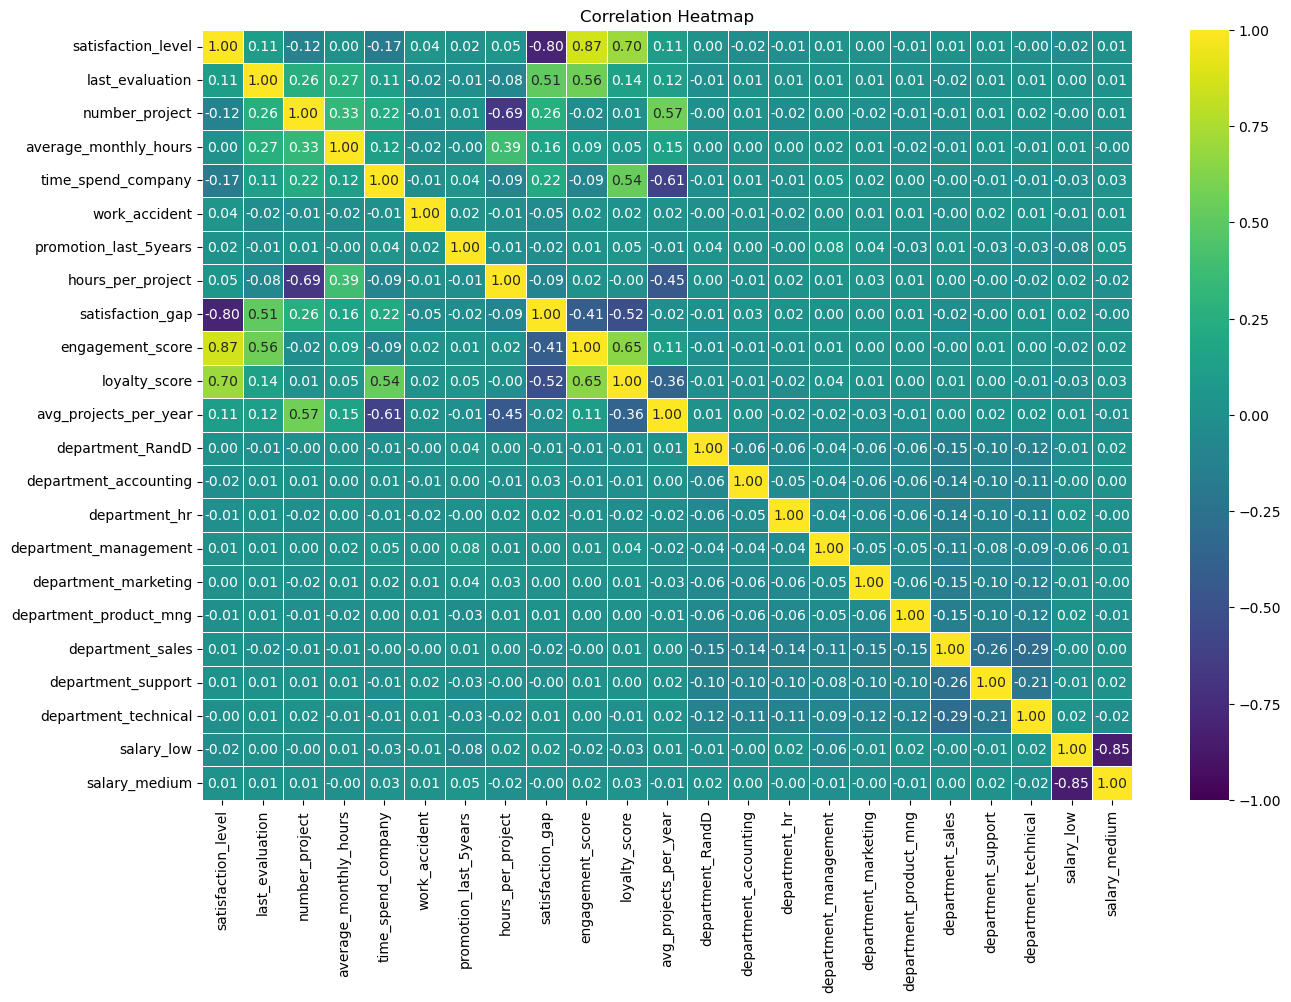

In [42]:
# Plot correlation heatmap
plt.figure(figsize = (15, 10)) 
sns.heatmap(X_train_treated.corr(numeric_only = True), annot = True, cmap = 'viridis', fmt = '.2f', linewidths = 0.5, vmin = -1, vmax = 1)
plt.title("Correlation Heatmap")
plt.show()

<div align="center">

<table>
  <thead>
    <tr>
      <th>Correlation Value (|r|)</th>
      <th>Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>&lt; 0.7</td>
      <td>🟢 Low correlation – Safe</td>
    </tr>
    <tr>
      <td>0.7 – 0.9</td>
      <td>🟠 Moderate to high – Inspect further</td>
    </tr>
    <tr>
      <td>&gt; 0.9</td>
      <td>🔴 Very high – Strong multicollinearity risk</td>
    </tr>
  </tbody>
</table>

</div>


Variable pairs with high multicollinearity (correlation ≥ 0.70):

* `satisfaction_gap` and `satisfaction_level`: -0.80
* `engagement_score` and `satisfaction_level`: 0.87
* `loyalty_score` and `satisfaction_level`: 0.70
* `salary_low` and `salary_medium`: -0.85

The variables of `satisfaction_gap`, `engagement_score` and `loyalty_score` are all feature engineered from `satisfaction_level`, so high pairwise correlations among them are expected. Similarly, `salary_low` and `salary_medium` stem from the same `salary` variable, and were one-hot encoded to meet the logistic regression model’s linearity assumption. To identify redundant variables, feature importance plots from the Random Forest and XGBoost models will be used to pinpoint features that can be removed without significantly impacting model performance.

## **Model Building**

### **Logistic Regression**

In [43]:
# Train Logistic Regression model
lr = LogisticRegression(max_iter = 5000).fit(X_train_treated, y_train)

# Print model coefficients and intercept
print(lr.coef_)
print(lr.intercept_)

[[-1.01626538e+01 -4.12104946e+00  2.65318454e+00  6.36203971e-03
  -4.25718230e+00 -1.40102560e+00 -7.26801468e-01 -2.70756307e-03
   6.04160432e+00 -1.29391239e+00  3.42984571e+00 -1.13066153e+01
  -4.62632640e-01 -1.59463576e-02 -5.36310352e-02 -2.61326386e-01
   7.72660408e-02 -2.02126545e-01 -2.32359002e-02 -2.12442859e-02
   1.08788849e-02  1.42988555e+00  1.03970997e+00]]
[14.95454191]


#### **Final Assumption: Linearity**

In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>
> The train set is used to evaluate the linearity assumption in logistic regression because the model is fitted on the training data, and the assumption concerns how well the model structure (i.e., the linear relationship between the logit of predicted probabilities and continuous predictors) fits that data.

In [44]:
# Get the predicted probabilities of the training data
training_probabilities = lr.predict_proba(X_train_treated)

# Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train_treated.copy()

# Create a new `logit` column in the `logit_data` df
logit_data['logit'] = np.log(training_probabilities[:,1] / training_probabilities[:,0])
logit_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,hours_per_project,satisfaction_gap,engagement_score,loyalty_score,avg_projects_per_year,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,logit
10388,0.65,0.65,5,180,2.0,0,0,36.000000,0.00,0.4225,1.30,2.500000,0,0,0,0,1,0,0,0,0,1,0,-11.377877
7447,0.73,0.72,3,166,3.0,0,0,55.333333,-0.01,0.5256,2.19,1.000000,0,0,0,0,0,0,0,0,1,0,1,-2.822225
9958,0.91,0.59,5,179,3.0,0,0,35.800000,-0.32,0.5369,2.73,1.666667,0,0,1,0,0,0,0,0,0,1,0,-5.921283
11004,0.83,0.91,3,155,3.0,0,0,51.666667,0.08,0.7553,2.49,1.000000,1,0,0,0,0,0,0,0,0,1,0,-3.489394
1080,0.86,0.95,4,238,5.0,0,0,59.500000,0.09,0.8170,4.30,0.800000,0,0,0,0,0,0,1,0,0,0,1,-0.814309


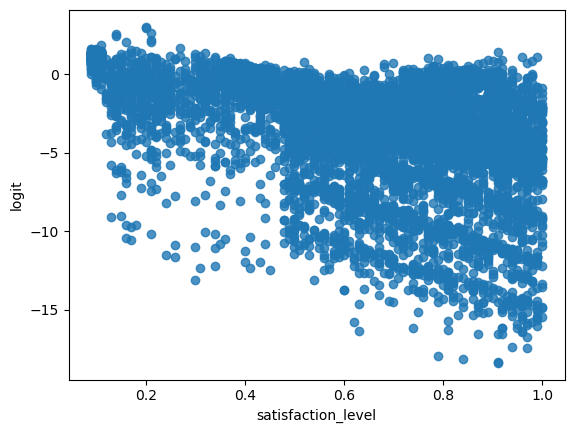

In [45]:
# Plot regplot of `satisfaction_level` log-odds
sns.regplot(x = 'satisfaction_level',
            y = 'logit',
            data = logit_data);

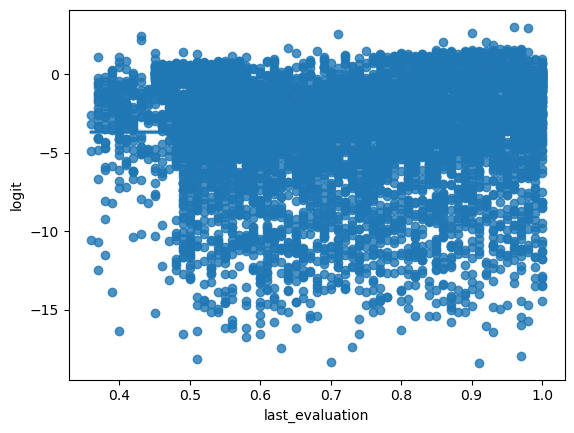

In [46]:
# Plot regplot of `last_evaluation` log-odds
sns.regplot(x = 'last_evaluation',
            y = 'logit',
            data = logit_data);

### **Gaussian Naive Bayes**

In [47]:
# Train Gaussian Naive Bayes model
gnb = naive_bayes.GaussianNB().fit(X_train_treated, y_train)

### **Random Forest**

In [48]:
%%time

# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state = 0)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'n_estimators': [100, 300],
    'max_depth': [10, 30],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.5, 0.9]}

# Define a list of scoring metrics to capture
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'recall')

# Fit the model to the training data
rf_cv.fit(X_train_raw, y_train)

CPU times: total: 3min 44s
Wall time: 3min 44s


,estimator,RandomForestC...andom_state=0)
,param_grid,"{'max_depth': [10, 30], 'max_features': ['sqrt', 'log2'], 'max_samples': [0.5, 0.9], 'min_samples_leaf': [1, 5], ...}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [49]:
# Save the trained Random Forest model to a file using pickle
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_cv, file)

In [50]:
# Display the best hyperparameters found by GridSearchCV
rf_cv.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [51]:
%%time

# Initialize optimized Random Forest classifier with selected hyperparameters
rf_opt = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 30,
    min_samples_leaf = 1,
    min_samples_split = 2,
    max_features = 'sqrt',
    max_samples = 0.9,
    random_state = 0)

# Fit the optimized model to the training data
rf_opt.fit(X_train_raw, y_train)

CPU times: total: 531 ms
Wall time: 521 ms


,n_estimators,100
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### **XGBoost**

In [52]:
%%time
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 0)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [4, 6],
    'min_child_weight': [3, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]}

# Define a list of scoring metrics to capture
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 5, refit = 'recall')

# Fit the model to the training data
xgb_cv = xgb_cv.fit(X_train_raw, y_train)

CPU times: total: 16min 9s
Wall time: 1min 24s


In [53]:
# Save the trained XGBoost model to a file using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_cv, file)

In [54]:
# Display the best hyperparameters found by GridSearchCV
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 150,
 'subsample': 1.0}

In [55]:
%%time

# Initialize optimized XGBoost classifier with selected hyperparameters
xgb_opt = XGBClassifier(
    colsample_bytree = 0.8,
    learning_rate = 0.2,
    max_depth = 4,
    min_child_weight = 3,
    n_estimators = 150,
    subsample = 1.0)

# Fit the optimized model to the training data
xgb_opt.fit(X_train_raw, y_train)

CPU times: total: 609 ms
Wall time: 64.8 ms


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## **Recall evaluation metrics**

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.

- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.

- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.

- **Accuracy** measures the proportion of data points that are correctly classified.

- **F1-score** is an aggregation of precision and recall.

## **Model Evaluation Using Validation Set**

In [56]:
# Create a dataframe to store model results
model_results = pd.DataFrame(
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

### **Logistic Regression**

Accuracy: 0.908674
Precision: 0.816254
Recall: 0.580402
F1 Score: 0.678414


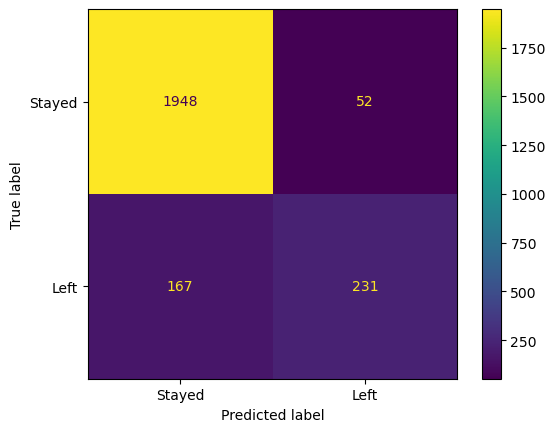

In [57]:
# Generate predictions on validation set
lr_y_val_pred = lr.predict(X_val_treated)

# Generate confusion matrix
lr_cm = metrics.confusion_matrix(y_val, lr_y_val_pred, labels = lr.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = ['Stayed', 'Left'])
disp.plot();

# Print evaluation metrics
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_val, lr_y_val_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_val, lr_y_val_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_val, lr_y_val_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_val, lr_y_val_pred))

In [58]:
# Create a dataframe to store model results
model_results = pd.DataFrame()

lr_metrics = {
    'Model': 'Logistic Regression - Validation',
    'Accuracy': metrics.accuracy_score(y_val, lr_y_val_pred),
    'Precision': metrics.precision_score(y_val, lr_y_val_pred),
    'Recall': metrics.recall_score(y_val, lr_y_val_pred),
    'F1 Score': metrics.f1_score(y_val, lr_y_val_pred)}

model_results = pd.concat([model_results, pd.DataFrame([lr_metrics])], ignore_index = True)

### **Gaussian Naive Bayes**

Accuracy: 0.845705
Precision: 0.523411
Recall: 0.786432
F1 Score: 0.628514


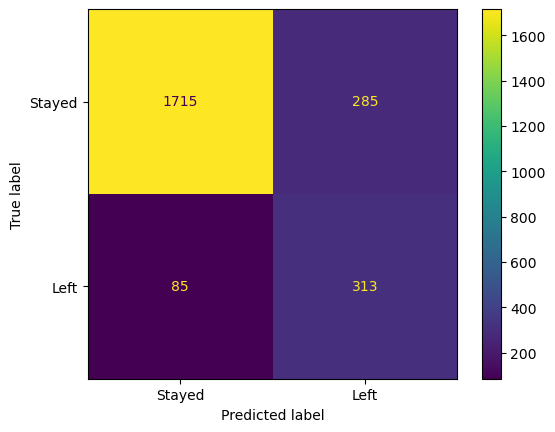

In [59]:
# Generate predictions on validation set
gnb_y_val_pred = gnb.predict(X_val_treated)

# Generate confusion matrix
gnb_cm = metrics.confusion_matrix(y_val, gnb_y_val_pred, labels = gnb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = gnb_cm, display_labels = ['Stayed', 'Left'])
disp.plot();

# Print evaluation metrics
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_val, gnb_y_val_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_val, gnb_y_val_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_val, gnb_y_val_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_val, gnb_y_val_pred))

In [60]:
gnb_metrics = {
    'Model': 'Gaussian Naive Bayes - Validation',
    'Accuracy': metrics.accuracy_score(y_val, gnb_y_val_pred),
    'Precision': metrics.precision_score(y_val, gnb_y_val_pred),
    'Recall': metrics.recall_score(y_val, gnb_y_val_pred),
    'F1 Score': metrics.f1_score(y_val, gnb_y_val_pred)}

# Add GNB metrics to results
model_results = pd.concat([model_results, pd.DataFrame([gnb_metrics])], ignore_index = True)

### **Random Forest**

Accuracy: 0.984570
Precision: 0.991826
Recall: 0.914573
F1 Score: 0.951634


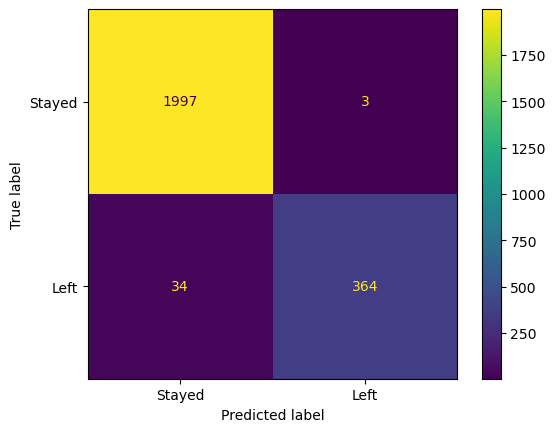

In [61]:
# Generate predictions on validation set
rf_y_val_pred = rf_opt.predict(X_val_raw)

# Generate confusion matrix
rf_cm = metrics.confusion_matrix(y_val, rf_y_val_pred, labels = rf_opt.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = ['Stayed', 'Left'])
disp.plot();

# Print evaluation metrics
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_val, rf_y_val_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_val, rf_y_val_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_val, rf_y_val_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_val, rf_y_val_pred))

In [62]:
rf_metrics = {
    'Model': 'Random Forest - Validation',
    'Accuracy': metrics.accuracy_score(y_val, rf_y_val_pred),
    'Precision': metrics.precision_score(y_val, rf_y_val_pred),
    'Recall': metrics.recall_score(y_val, rf_y_val_pred),
    'F1 Score': metrics.f1_score(y_val, rf_y_val_pred)}

# Add Random Forest metrics to results
model_results = pd.concat([model_results, pd.DataFrame([rf_metrics])], ignore_index = True)

### **XGBoost**

Accuracy: 0.982068
Precision: 0.978437
Recall: 0.912060
F1 Score: 0.944083


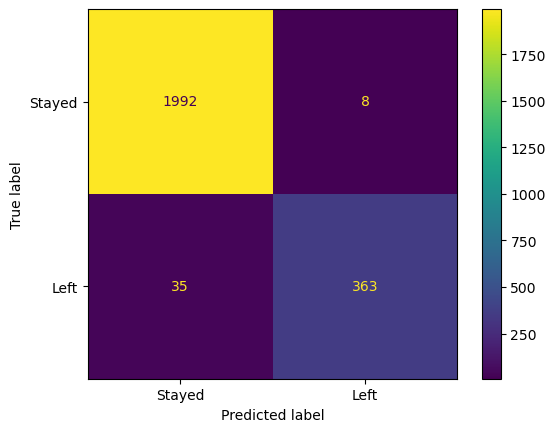

In [63]:
# Generate predictions on validation set
xgb_y_val_pred = xgb_opt.predict(X_val_raw)

# Generate confusion matrix
xgb_cm = metrics.confusion_matrix(y_val, xgb_y_val_pred, labels = xgb_opt.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels = ['Stayed', 'Left'])
disp.plot();

# Print evaluation metrics
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_val, xgb_y_val_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_val, xgb_y_val_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_val, xgb_y_val_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_val, xgb_y_val_pred))

In [64]:
xgb_metrics = {
    'Model': 'XGBoost - Validation',
    'Accuracy': metrics.accuracy_score(y_val, xgb_y_val_pred),
    'Precision': metrics.precision_score(y_val, xgb_y_val_pred),
    'Recall': metrics.recall_score(y_val, xgb_y_val_pred),
    'F1 Score': metrics.f1_score(y_val, xgb_y_val_pred)}

# Add XGBoost metrics to results
model_results = pd.concat([model_results, pd.DataFrame([xgb_metrics])], ignore_index = True)

### **Model Comparison**

In [65]:
model_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression - Validation,0.908674,0.816254,0.580402,0.678414
1,Gaussian Naive Bayes - Validation,0.845705,0.523411,0.786432,0.628514
2,Random Forest - Validation,0.984570,0.991826,0.914573,0.951634
3,XGBoost - Validation,0.982068,0.978437,0.912060,0.944083


Based on the evaluation metrics, the Random Forest model is the strongest overall performer. It achieved the highest accuracy (98.5%), precision (99.2%), recall (91.5%), and F1 score (95.2%), indicating that it not only makes accurate predictions but also balances false positives and false negatives effectively.

While XGBoost also performed well with similar recall (91.2%) and a strong F1 score (94.4%), Random Forest slightly edged it out in both precision and overall consistency.

In contrast, Logistic Regression and Gaussian Naive Bayes underperformed, especially in recall, which is critical for detecting churned employees. Logistic Regression had high precision (81.6%) but low recall (58.0%), while Gaussian Naive Bayes had moderate recall (78.6%) but low precision (52.3%).

In conclusion, Random Forest is the best model among the four and should be selected as the final model for deployment and evaluation on the unseen test set.

## **Retraining Champion Model**

In [66]:
# Combine train and validation sets
X_trainval_raw = pd.concat([X_train_raw, X_val_raw], axis = 0)
y_trainval = pd.concat([y_train, y_val], axis = 0)

In [67]:
%%time

# Initialize optimized Random Forest classifier with selected hyperparameters
rf_opt = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 30,
    min_samples_leaf = 1,
    min_samples_split = 2,
    max_features = 'sqrt',
    max_samples = 0.9,
    random_state = 0)

# Fit the optimized model to the training + validation data
rf_opt.fit(X_trainval_raw, y_trainval)

CPU times: total: 672 ms
Wall time: 674 ms


,n_estimators,100
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## **Model Evaluation Using Test Set**

Accuracy: 0.983743
Precision: 0.991781
Recall: 0.909548
F1 Score: 0.948886


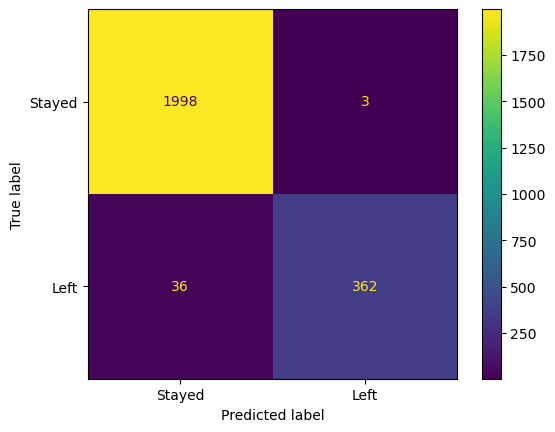

In [68]:
# Generate predictions on test set
rf_y_test_pred = rf_opt.predict(X_test_raw)

# Generate confusion matrix
rf_cm = metrics.confusion_matrix(y_test, rf_y_test_pred, labels = rf_opt.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = ['Stayed', 'Left'])
disp.plot();

# Print evaluation metrics
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, rf_y_test_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, rf_y_test_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, rf_y_test_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, rf_y_test_pred))

In [69]:
# Create a dataframe to store model results
test_results = pd.DataFrame()

rf_test_metrics = {
    'Model': 'Random Forest - Test',
    'Accuracy': metrics.accuracy_score(y_test, rf_y_test_pred),
    'Precision': metrics.precision_score(y_test, rf_y_test_pred),
    'Recall': metrics.recall_score(y_test, rf_y_test_pred),
    'F1 Score': metrics.f1_score(y_test, rf_y_test_pred)}

# Compare Random Forest results for validation and test sets
test_results = pd.concat([test_results, model_results[model_results['Model'] == 'Random Forest - Validation'], pd.DataFrame([rf_test_metrics])], ignore_index = True)

### **Model Comparison**

In [70]:
test_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest - Validation,0.984570,0.991826,0.914573,0.951634
1,Random Forest - Test,0.983743,0.991781,0.909548,0.948886


The Random Forest model demonstrates excellent and consistent performance on both validation and test sets, with high accuracy, precision, and F1 scores. While recall slightly decreases on the test set, the difference is minimal, indicating good generalization and reliable prediction of employee churn. Overall, the model is robust with strong predictive capabilities.

## **Feature Importance**

### **Logistic Regression**

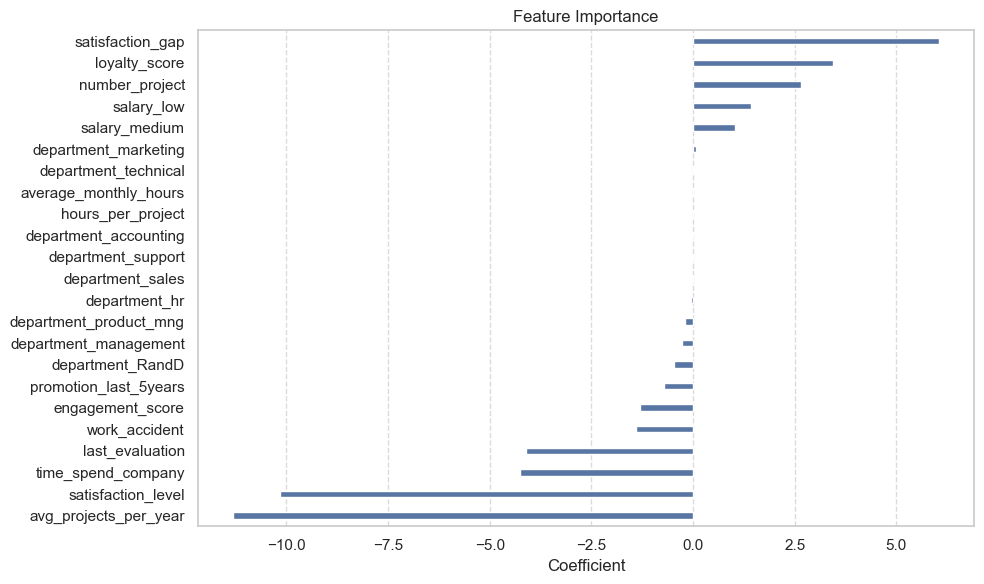

In [71]:
# Plot the feature importances
model_coef = pd.DataFrame(zip(X_train_treated.columns, [float(c) for c in lr.coef_[0]]),
                          columns = ['Feature', 'Coefficient'])
model_coef_sorted = model_coef.sort_values(by = 'Coefficient', ascending = False)
plt.figure(figsize = (10, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x = model_coef_sorted['Coefficient'], y = model_coef_sorted['Feature'], orient = 'h', width = 0.3)
plt.ylabel('')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Random Forest**

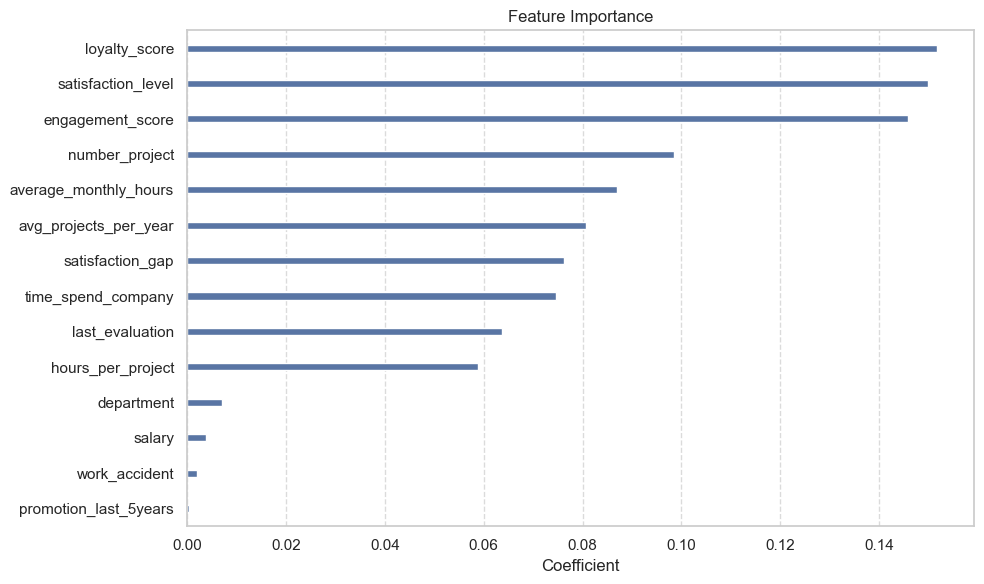

In [72]:
# Plot the feature importances
model_coef = pd.DataFrame(zip(X_trainval_raw.columns, [float(c) for c in rf_opt.feature_importances_]),
                          columns = ['Feature', 'Coefficient'])
model_coef_sorted = model_coef.sort_values(by = 'Coefficient', ascending = False)
plt.figure(figsize = (10, 6))
sns.set_theme(style = "whitegrid")
sns.barplot(x = model_coef_sorted['Coefficient'], y = model_coef_sorted['Feature'], orient = 'h', width = 0.2)
plt.ylabel('')
plt.title('Feature Importance')
plt.grid(axis = 'x', linestyle = '--', alpha=0.7)
plt.tight_layout()
plt.show()

### **XGBoost**

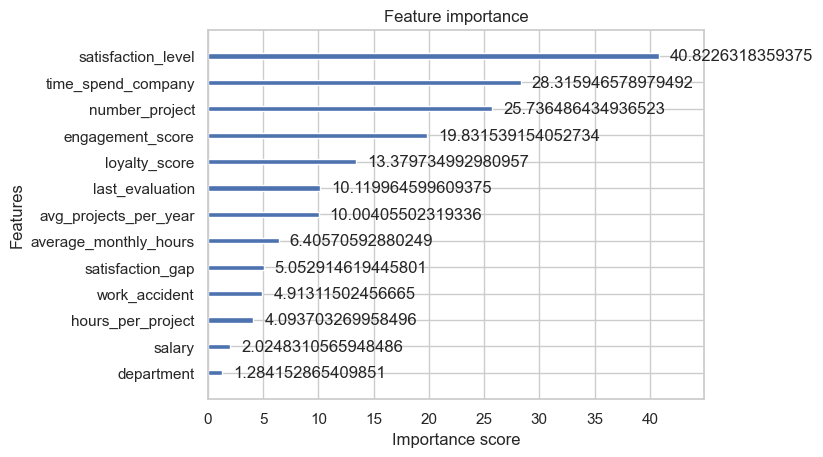

In [73]:
# Plot the feature importances
plot_importance(xgb_opt, importance_type = 'gain');

## **Comparative Feature Selection**

### **Logistic Regression**

In [74]:
# Min-max scale absolute logistic regression coefficients
lr_coefs = np.abs(lr.coef_[0])

lr_coefs_min = np.min(lr_coefs)
lr_coefs_max = np.max(lr_coefs)
lr_coefs_scaled = (lr_coefs - lr_coefs_min) / (lr_coefs_max - lr_coefs_min)

print(lr_coefs_scaled)

[8.98799464e-01 3.64329044e-01 2.34474399e-01 3.23293212e-04
 3.76372034e-01 1.23702181e-01 6.40569547e-02 0.00000000e+00
 5.34230896e-01 1.14226412e-01 3.03181716e-01 1.00000000e+00
 4.06872639e-02 1.17116973e-03 4.50494407e-03 2.28787097e-02
 6.59581443e-03 1.76415968e-02 1.81603898e-03 1.63985086e-03
 7.22875845e-04 1.26255275e-01 9.17383997e-02]


In [75]:
# Create DataFrame of scaled LR coefficients with feature names
lr_importance_df = pd.DataFrame(zip(X_train_treated.columns, [float(c) for c in lr_coefs_scaled]), columns = ['Feature', 'Score'])

# Helper function to assign groups
def group_feature(name):
    if name.startswith('department_'):
        return 'department'
    elif name.startswith('salary_'):
        return 'salary'
    else:
        return name

# Apply grouping
lr_importance_df['Group'] = lr_importance_df['Feature'].apply(group_feature)

# Average importance per group
lr_fi_df = (
    lr_importance_df.groupby('Group', as_index=False)['Score'].mean().sort_values(by = 'Score', ascending = False))

lr_fi_df.reset_index(drop = True, inplace = True)

# Rename columns for consistency
lr_fi_df.rename(columns = {'Group': 'Feature'}, inplace = True)

lr_fi_df

,Feature,Score
0,avg_projects_per_year,1.000000
1,satisfaction_level,0.898799
2,satisfaction_gap,0.534231
3,time_spend_company,0.376372
4,last_evaluation,0.364329
5,loyalty_score,0.303182
6,number_project,0.234474
7,work_accident,0.123702
8,engagement_score,0.114226
9,salary,0.108997


### **Random Forest**

In [76]:
# Extract feature importances from Random Forest model
rf_coefs = rf_opt.feature_importances_

# Min-max scale Random Forest feature importances
rf_coefs_min = np.min(rf_coefs)
rf_coefs_max = np.max(rf_coefs)
rf_coefs_scaled = (rf_coefs - rf_coefs_min) / (rf_coefs_max - rf_coefs_min)

# Create DataFrame of scaled RF coefficients with feature names
rf_fi_df = pd.DataFrame(zip(X_trainval_raw.columns, rf_coefs_scaled), columns = ['Feature', 'Score'])

rf_fi_df

,Feature,Score
0,satisfaction_level,0.988186
1,last_evaluation,0.419124
2,number_project,0.648400
3,average_monthly_hours,0.572480
4,time_spend_company,0.490593
5,work_accident,0.011496
6,promotion_last_5years,0.000000
7,department,0.045080
8,salary,0.023129
9,hours_per_project,0.386615


### **XGBoost**

In [77]:
# Extract feature importances from XGBoost model
xgb_coefs = xgb_opt.feature_importances_

# Min-max scale XGBoost feature importances
xgb_coefs_min = np.min(xgb_coefs)
xgb_coefs_max = np.max(xgb_coefs)
xgb_coefs_scaled = (xgb_coefs - xgb_coefs_min) / (xgb_coefs_max - xgb_coefs_min)

# Create DataFrame of scaled XGBoost coefficients with feature names
xgb_fi_df = pd.DataFrame(zip(X_train_raw.columns, xgb_coefs_scaled), columns = ['Feature', 'Score'])

xgb_fi_df

,Feature,Score
0,satisfaction_level,1.000000
1,last_evaluation,0.247901
2,number_project,0.630447
3,average_monthly_hours,0.156916
4,time_spend_company,0.693633
5,work_accident,0.120353
6,promotion_last_5years,0.000000
7,department,0.031457
8,salary,0.049601
9,hours_per_project,0.100280


### **Compare Scaled Feature Importances Across Models**

In [78]:
# Combine all model scores together
fi_all_df = lr_fi_df.merge(rf_fi_df, on = 'Feature').merge(xgb_fi_df, on = 'Feature').rename(columns = {'Score_x' : 'lr_score', 'Score_y' : 'rf_score', 'Score' : 'xgb_score'})

# Create a new column to determine aggregate score per feature
fi_all_df['mean_score'] = fi_all_df[['lr_score', 'rf_score', 'xgb_score']].mean(axis = 1)

# Sort the new column by descending score
fi_all_df = fi_all_df.sort_values(by = 'mean_score', ascending = False).reset_index(drop = True)

# Highlight the rows where the aggregated feature importance score falls below a pre-specified threshold
threshold = 0.1 * max(fi_all_df['mean_score'])

def highlight_row(row):
    if row['mean_score'] < threshold:
        return ['background-color: lightcoral; border: 2px solid red;'] * len(row)
    return [''] * len(row)

fi_all_df = fi_all_df.style.apply(highlight_row, axis = 1)

fi_all_df

,Feature,lr_score,rf_score,xgb_score,mean_score
0,satisfaction_level,0.898799,0.988186,1.000000,0.962329
1,avg_projects_per_year,1.000000,0.531738,0.245061,0.592266
2,loyalty_score,0.303182,1.000000,0.327753,0.543645
3,engagement_score,0.114226,0.962070,0.485798,0.520698
4,time_spend_company,0.376372,0.490593,0.693633,0.520200
5,number_project,0.234474,0.648400,0.630447,0.504440
6,satisfaction_gap,0.534231,0.501427,0.123777,0.386479
7,last_evaluation,0.364329,0.419124,0.247901,0.343785
8,average_monthly_hours,0.000323,0.572480,0.156916,0.243239
9,hours_per_project,0.000000,0.386615,0.100280,0.162298


* `work_accident`, `salary`, `department` and `promotion_last_5years` were removed due to their consistently low feature importance in the Logistic Regression, Random Forest and XGBoost models, indicating minimal contribution to model performance. The aim of removing these variables is to simplify the model, reduce noise, and improve generalizability by focusing on the most relevant predictors.

* Despite Random Forest being the best-performing model in terms of predictive accuracy, logistic regression remains valuable for its interpretability, as it offers clear, intuitive coefficient outputs that help stakeholders understand how different features influence employees leaving, enabling more actionable business decisions.

* Stakeholders with non-technical backgrounds can better engage with and trust a transparent model like logistic regression compared to a black-box ensemble model. Therefore, optimizing logistic regression ensures a strong, interpretable baseline and facilitates easier deployment and maintenance compared to more complex models.

* While Random Forest will be used for actual predictions due to its high recall, the optimized Logistic Regression model complements it by providing a clear, interpretable overview of key factors driving employee churn.

## **Revised Logistic Regression Model**

### **Feature Pruning**

In [79]:
# Create a copy of the encoded predictor sets and drop the `salary` and `department` variables
X_train_trimmed = X_train_treated.iloc[:, :12].copy()
X_val_trimmed = X_val_treated.iloc[:, :12].copy()
X_test_trimmed = X_test_treated.iloc[:, :12].copy()

df_trimmed = [X_train_trimmed, X_val_trimmed, X_test_trimmed]

# Drop `work_accident` and `promotion_last_5years` variables
for df in df_trimmed:
    df.drop(columns = ['work_accident', 'promotion_last_5years'], inplace = True)

### **Model Building**

In [80]:
# Build the logistic regression model using the revised train set
lr_revised = LogisticRegression(max_iter = 5000).fit(X_train_trimmed, y_train)

# Show descriptive statistics of the revised logistic regression model
print(lr_revised.coef_)
print(lr_revised.intercept_)

[[-1.05236522e+01 -4.37264641e+00  2.76639675e+00  7.15005326e-03
  -4.44189023e+00 -4.32635056e-03  6.15100581e+00 -8.88881171e-01
   3.47584233e+00 -1.18084916e+01]]
[16.75896869]


### **Model Evaluation using Validation Set**

Accuracy: 0.891159
Precision: 0.784232
Recall: 0.474874
F1 Score: 0.591549


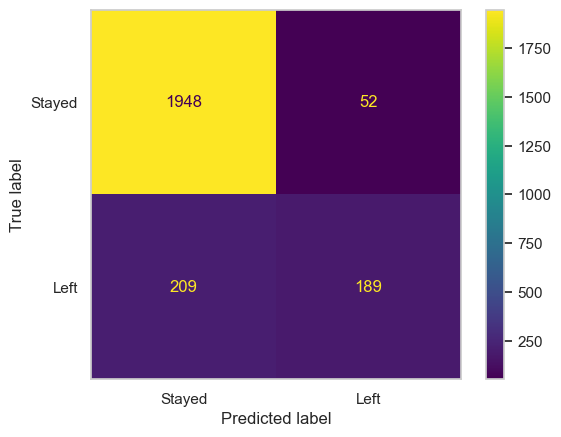

In [81]:
# Generate predictions on trimmed validation set
lr_revised_pred = lr_revised.predict(X_val_trimmed)

# Generate confusion matrix
lr_revised_cm = metrics.confusion_matrix(y_val, lr_revised_pred, labels = lr_revised.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_revised_cm, display_labels = ['Stayed', 'Left'])
disp.plot().ax_.grid(False);

# Print evaluation metrics
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_val, lr_revised_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_val, lr_revised_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_val, lr_revised_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_val, lr_revised_pred))

In [82]:
# Create a dataframe to store model results
lr_model_results = pd.DataFrame()

lr_val_noopt_metrics = {
    'Model': 'LR - Validation (No threshold opt)',
    'Accuracy': metrics.accuracy_score(y_val, lr_revised_pred),
    'Precision': metrics.precision_score(y_val, lr_revised_pred),
    'Recall': metrics.recall_score(y_val, lr_revised_pred),
    'F1 Score': metrics.f1_score(y_val, lr_revised_pred)}

# Store Logistic Regression results for validation set without threshold optimization
lr_model_results = pd.concat([lr_model_results, pd.DataFrame([lr_val_noopt_metrics])], ignore_index = True)

### **Optimal Threshold for Classification**

#### **Logistic Regression - No Feature Pruning**

In [83]:
# true binary labels
y_true = y_val

# predicted probabilities for positive class
y_probs = lr.predict_proba(X_val_treated)[: ,1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Calculate Youden's J statistic for each threshold
J = tpr - fpr

# Find the index of the max J
ix = J.argmax()

optimal_threshold = thresholds[ix]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"TPR (Recall) at optimal threshold: {tpr[ix]}")
print(f"FPR at optimal threshold: {fpr[ix]}")

Optimal Threshold: 0.2704959914050528
TPR (Recall) at optimal threshold: 0.9095477386934674
FPR at optimal threshold: 0.0985


#### **Logistic Regression - Feature Pruning**

In [84]:
# true binary labels
y_true = y_val

# predicted probabilities for positive class
y_probs = lr_revised.predict_proba(X_val_trimmed)[: ,1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Calculate Youden's J statistic for each threshold
J = tpr - fpr

# Find the index of the max J
ix = J.argmax()

optimal_threshold = thresholds[ix]

# Display optimal threshold and corresponding TPR (Recall) and FPR
print(f"Optimal Threshold: {optimal_threshold}")
print(f"TPR (Recall) at optimal threshold: {tpr[ix]}")
print(f"FPR at optimal threshold: {fpr[ix]}")

Optimal Threshold: 0.27610377544281545
TPR (Recall) at optimal threshold: 0.9447236180904522
FPR at optimal threshold: 0.096


### **Model Re-Evaluation using Validation Set**

Accuracy: 0.910759
Precision: 0.661972
Recall: 0.944724
F1 Score: 0.778468


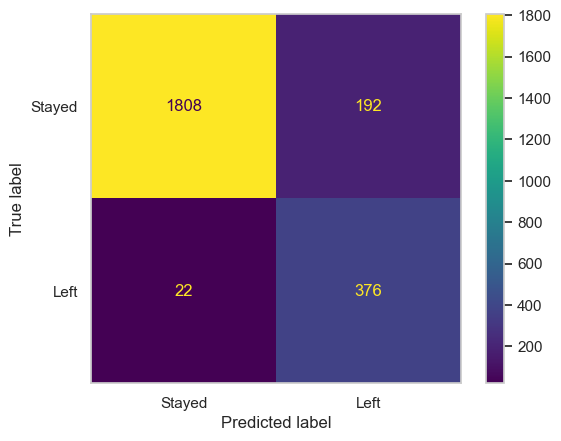

In [85]:
# Apply the optimal threshold to get class predictions
y_pred_opt = (y_probs >= optimal_threshold).astype(int)

lr_opt_cm = metrics.confusion_matrix(y_val, y_pred_opt, labels = lr.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_opt_cm, display_labels = ['Stayed', 'Left'])
disp.plot().ax_.grid(False);

# Now calculate evaluation metrics using y_val and y_pred_opt
accuracy = metrics.accuracy_score(y_val, y_pred_opt)
precision = metrics.precision_score(y_val, y_pred_opt)
recall = metrics.recall_score(y_val, y_pred_opt)
f1 = metrics.f1_score(y_val, y_pred_opt)

# Print evaluation metrics
print("Accuracy:", "%.6f" % accuracy)
print("Precision:", "%.6f" % precision)
print("Recall:", "%.6f" % recall)
print("F1 Score:", "%.6f" % f1)

In [86]:
lr_val_opt_metrics = {
    'Model': 'LR - Validation (Threshold opt)',
    'Accuracy': metrics.accuracy_score(y_val, y_pred_opt),
    'Precision': metrics.precision_score(y_val, y_pred_opt),
    'Recall': metrics.recall_score(y_val, y_pred_opt),
    'F1 Score': metrics.f1_score(y_val, y_pred_opt)}

# Compare Logistic Regression results for validation set with threshold optimization
lr_model_results = pd.concat([lr_model_results, pd.DataFrame([lr_val_opt_metrics])], ignore_index = True)

### **Retraining Model**

In [87]:
# Merge trimmed train and validation sets for final training
X_trainval_trimmed = pd.concat([X_train_trimmed, X_val_trimmed], axis = 0)

In [88]:
# Build the logistic regression model using the revised train set
lr_revised_opt = LogisticRegression(max_iter = 5000).fit(X_trainval_trimmed, y_trainval)

# Show descriptive statistics of the revised logistic regression model
print(lr_revised_opt.coef_)
print(lr_revised_opt.intercept_)

[[-1.19094568e+01 -5.13852342e+00  3.17019758e+00  7.65559247e-03
  -5.03581629e+00 -4.56198077e-03  6.77093337e+00 -4.76413620e-01
   3.88930968e+00 -1.34584836e+01]]
[19.20635114]


### **Model Evaluation Using Test Set**

#### **Performance w/o threshold optimization**

Accuracy: 0.903293
Precision: 0.800725
Recall: 0.555276
F1 Score: 0.655786


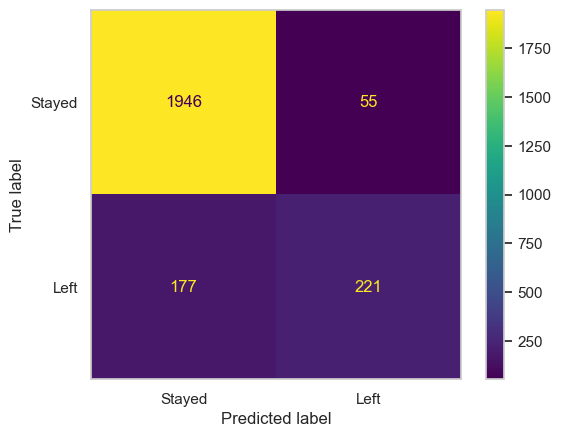

In [89]:
# Generate predictions on trimmed test set
lr_opt_pred = lr_revised_opt.predict(X_test_trimmed)

# Generate confusion matrix
lr_opt_cm = metrics.confusion_matrix(y_test, lr_opt_pred, labels = lr_revised_opt.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_opt_cm, display_labels = ['Stayed', 'Left'])
disp.plot().ax_.grid(False);

# Print evaluation metrics
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, lr_opt_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, lr_opt_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, lr_opt_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, lr_opt_pred))

In [90]:
lr_test_noopt_metrics = {
    'Model': 'LR - Test (No Threshold opt)',
    'Accuracy': metrics.accuracy_score(y_test, lr_opt_pred),
    'Precision': metrics.precision_score(y_test, lr_opt_pred),
    'Recall': metrics.recall_score(y_test, lr_opt_pred),
    'F1 Score': metrics.f1_score(y_test, lr_opt_pred)}

# Compare Logistic Regression results for test set without threshold optimization
lr_model_results = pd.concat([lr_model_results, pd.DataFrame([lr_test_noopt_metrics])], ignore_index = True)

#### **Performance with threshold optimization**

In [91]:
# true binary labels
y_true = y_test

# predicted probabilities for positive class
y_probs = lr_revised_opt.predict_proba(X_test_trimmed)[: ,1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Calculate Youden's J statistic for each threshold
J = tpr - fpr

# Find the index of the max J
ix = J.argmax()

optimal_threshold = thresholds[ix]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"TPR (Recall) at optimal threshold: {tpr[ix]}")
print(f"FPR at optimal threshold: {fpr[ix]}")

Optimal Threshold: 0.29343088686500896
TPR (Recall) at optimal threshold: 0.9195979899497487
FPR at optimal threshold: 0.09645177411294353


Accuracy: 0.9062
Precision: 0.6547
Recall: 0.9196
F1 Score: 0.7649


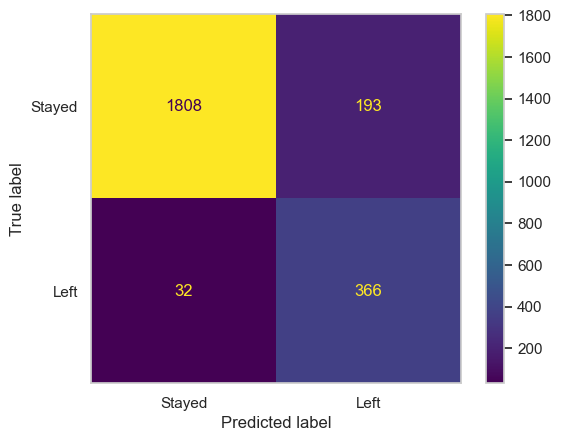

In [92]:
# Apply the optimal threshold to get class predictions
y_pred_test = (y_probs >= optimal_threshold).astype(int)

lr_test_opt_cm = metrics.confusion_matrix(y_test, y_pred_test, labels = lr_revised_opt.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_test_opt_cm, display_labels = ['Stayed', 'Left'])
disp.plot().ax_.grid(False);

# Now calculate evaluation metrics using y_val and y_pred_opt
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [93]:
lr_test_opt_metrics = {
    'Model': 'LR - Test (Threshold opt)',
    'Accuracy': metrics.accuracy_score(y_test, y_pred_test),
    'Precision': metrics.precision_score(y_test, y_pred_test),
    'Recall': metrics.recall_score(y_test, y_pred_test),
    'F1 Score': metrics.f1_score(y_test, y_pred_test)}

# Compare Logistic Regression results for test set with threshold optimization
lr_model_results = pd.concat([lr_model_results, pd.DataFrame([lr_test_opt_metrics])], ignore_index = True)

### **Logistic Regression Comparison: Default vs Optimized Threshold**

In [94]:
lr_model_results

,Model,Accuracy,Precision,Recall,F1 Score
0,LR - Validation (No threshold opt),0.891159,0.784232,0.474874,0.591549
1,LR - Validation (Threshold opt),0.910759,0.661972,0.944724,0.778468
2,LR - Test (No Threshold opt),0.903293,0.800725,0.555276,0.655786
3,LR - Test (Threshold opt),0.906211,0.654741,0.919598,0.764890


## **Conclusion**

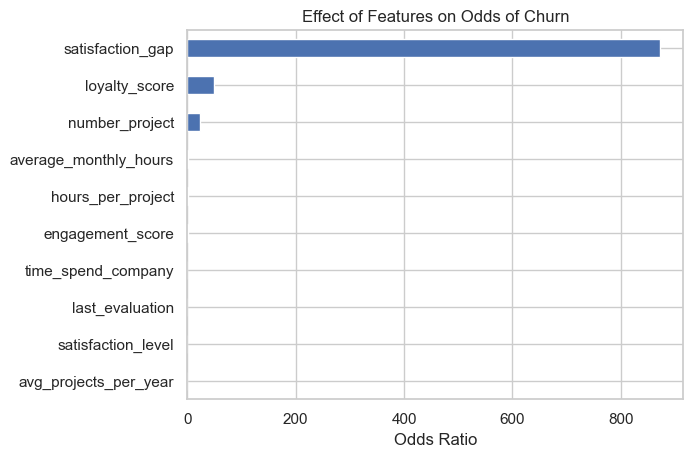

In [95]:
# Plot odds ratios of logistic regression features affecting churn
coefs = pd.Series(np.exp(lr_revised_opt.coef_[0]), index = X_train_trimmed.columns)
coefs.sort_values().plot(kind = 'barh')
plt.title("Effect of Features on Odds of Churn")
plt.xlabel("Odds Ratio")
plt.show()

The odds ratio plot highlights `satisfaction_gap` as the most significant driver of employee churn, followed by `loyalty_score` and `number_project`. 

* A large `satisfaction_gap`, where current satisfaction is much lower than past engagement—suggests a decline in employee morale or unmet expectations over time. To address this, conducting stay interviews can help managers understand what’s changed and what specific support employees need to stay engaged.

* A low `loyalty_score` indicates a weak sense of long-term connection to the company, which can be mitigated through personalized career development planning, such as offering internal mobility opportunities, clear promotion pathways, or funded professional certifications.

*  Meanwhile, employees handling a high `number_of_projects` may face burnout or feel unsupported. Introducing workload balancing policies or assigning mentors to help them navigate responsibilities can improve both performance and retention.

These tailored interventions not only target key churn drivers but also foster a stronger sense of value, purpose, and belonging within the organization.

In [96]:
pd.concat([test_results.iloc[[1]], lr_model_results.iloc[[3]]], ignore_index = True)

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest - Test,0.983743,0.991781,0.909548,0.948886
1,LR - Test (Threshold opt),0.906211,0.654741,0.919598,0.764890


Building on the model insights, the Random Forest model will be leveraged for predicting employee churn due to its superior performance on both the validation and test sets. While the Logistic Regression model has a slightly higher recall, the Random Forest maintains a high recall (0.91) while significantly outperforming in precision (0.99) and F1 score (0.95). In the context of this imbalanced dataset, high recall ensures most at-risk employees are identified for timely intervention, while high precision is critical to minimize false positives and avoid unnecessary retention efforts that waste resources. This effective balance makes Random Forest the preferred choice for deployment, as it reliably flags likely churners while reducing costly false alarms. Meanwhile, the Logistic Regression model provides valuable interpretability and actionable insights into key churn drivers. Together, these models complement each other by combining strong predictive accuracy with transparent explanation, supporting robust and data-driven retention strategies.